# Task: Use state of art libraries for Approximate Nearest Neighbor Search for your favorite data set.

## Importing the Libraries

In [2]:
!pip install nmslib

     |████████████████████████████████| 13.5 MB 9.9 MB/s 
     |████████████████████████████████| 188 kB 47.8 MB/s 


In [3]:
!pip install faiss

     |████████████████████████████████| 4.7 MB 12.1 MB/s 


In [4]:
!apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 0s (2,831 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.

In [5]:
!pip install annoy

     |████████████████████████████████| 646 kB 10.6 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391607 sha256=9796aaa071c2bce19bb041c39aad8d06d5956c48f1e2c7a62655df83e58159f8
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

## Loading and Understanding the Dataset

In [8]:
digits = load_digits(n_class = 9)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
X.shape

(1617, 64)

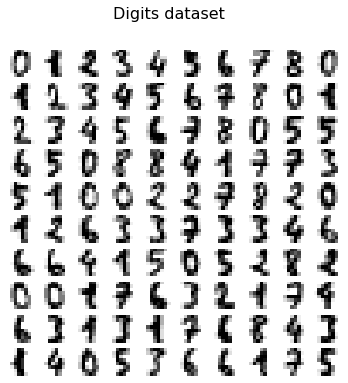

In [9]:
fig, axs = plt.subplots(nrows = 10, ncols = 10, figsize = (6, 6))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap = plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("Digits dataset", fontsize = 16)

## Transforming the Data

In [10]:
from sklearn.manifold import TSNE

tsne_2 = TSNE()
data_embeddings_tsne_2 = tsne_2.fit_transform(X)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [11]:
data_embeddings_tsne_2.shape

(1617, 2)

## Hierarchical Navigable Small Worlds (HNSW)

In [12]:
import nmslib

In [13]:
hnsw_index = nmslib.init(method = 'hnsw', space = 'cosinesimil')
hnsw_index.addDataPointBatch(data_embeddings_tsne_2)
hnsw_index.createIndex({'post': 2})

In [14]:
y[80]

6

In [15]:
hnsw_output = hnsw_index.knnQuery(data_embeddings_tsne_2[80], k = 10)
hnsw_output_list = [y[i] for i in hnsw_output[0]]
hnsw_output_list

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

## Exhaustive Search

This technique will help to find similar objects in the dataset using faiss library.

In [16]:
import faiss

In [17]:
exhaustive_search = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
exhaustive_search.add(data_embeddings_tsne_2)

In [18]:
distances, indices = exhaustive_search.search(data_embeddings_tsne_2[80:81], 10) 
exhaustive_search_output_list = [y[i] for i in indices[0]]

Now, it's easy to search similar values as indices[0].

In [19]:
exhaustive_search_output_list

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

It's showing the exact search.

## Product Quantization

In [20]:
number_of_partition = 8
search_in_x_partitions = 2
subvector_size = 8

pq_quantizer = faiss.IndexFlatL2(data_embeddings_tsne_2.shape[1])
pq = faiss.IndexIVFPQ(pq_quantizer, data_embeddings_tsne_2.shape[1], number_of_partition, search_in_x_partitions, subvector_size)
pq.train(data_embeddings_tsne_2)
pq.add(data_embeddings_tsne_2)

In [21]:
distances, indices = pq.search(data_embeddings_tsne_2[90:91], 10) 
pq_output_list =  [y[i] for i in indices[0]]
pq_output_list

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

It's showing the exact search.

## Locality Sensitive Hashing (LSH)

In [22]:
lsh = faiss.IndexLSH(data_embeddings_tsne_2.shape[1], 4)
lsh.add(data_embeddings_tsne_2)

In [23]:
distances, indices = lsh.search(data_embeddings_tsne_2[80:81], k=10)
lsh_output_list =  [y[i] for i in indices[0]]
lsh_output_list

[6, 6, 1, 1, 6, 6, 1, 1, 1, 1]

It's showing the similar search not the exact search.

## Trees and Graphs

One of the most prominient application of Tree-based application ANN is Annoy.

In Annoy, in order to construct the index we create a forest (aka many trees) Each tree is constructed in the following way, we pick two points at random and split the space into two by their hyperplane, we keep splitting into the subspaces recursively until the points associated with a node is small enough.

In [24]:
import annoy

In [25]:
number_of_trees = 5
annoy_index = annoy.AnnoyIndex(data_embeddings_tsne_2.shape[1])
for i, vec in enumerate(data_embeddings_tsne_2):
  annoy_index.add_item(i, vec.tolist())
annoy_index.build(number_of_trees)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

In [26]:
annoy_indices = annoy_index.get_nns_by_vector(data_embeddings_tsne_2[90].tolist(), 10)
annoy_output_list = [y[i] for i in annoy_indices]

In [27]:
annoy_output_list

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

It's showing the exact search.

In [28]:
graph_index = faiss.IndexHNSWFlat(data_embeddings_tsne_2.shape[1], 10)
graph_index.add(data_embeddings_tsne_2)

distances, indices = graph_index.search(data_embeddings_tsne_2[90:91], k=10)
graph_output_list = [y[i] for i in indices[0]]
graph_output_list

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

It's showing the exact search.